# This notebook focus on a single time frame such that dT/dt = 0

In [3]:
import numpy
import torch
import os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)
# PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [5]:
## Load data
file_paths, file_num = file_path(r"./Data/data20231208")
# 初始化从文件中提取的数据
file_x = torch.empty(0)
file_y = torch.empty(0)
file_z = torch.empty(0)
file_temp = torch.empty(0)
file_total_heat = torch.empty(0)

# 遍历列表，逐个处理文件
for file_path in file_paths:
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = lines[1:]
        # 初始化空列表来存储处理后的数据
        processed_data = []

        for line in data:
            parts = line.strip().split()
            processed_line = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5])]
            processed_data.append(processed_line)
        tensor_data = torch.tensor(processed_data)
        file_x = torch.cat((file_x, tensor_data[:, 0]), dim=0)
        file_y = torch.cat((file_y, tensor_data[:, 1]), dim=0)
        file_z = torch.cat((file_z, tensor_data[:, 2]), dim=0)
        file_temp = torch.cat((file_temp, tensor_data[:, 3]), dim=0)
        file_total_heat = torch.cat((file_total_heat, tensor_data[:, 4]), dim=0)

# 构建张量
nodes_num = len(data)
nodes = torch.linspace(1, nodes_num, nodes_num)
t = torch.linspace(0, 30 * (file_num-1), file_num)
T, N = torch.meshgrid(t, nodes, indexing='ij')
X = torch.empty_like(N)
Y = torch.empty_like(N)
Z = torch.empty_like(N)
temp = torch.empty_like(N)
total_heat = torch.empty_like(N)

# 使用循环填入张量
index = 0  # 初始化索引
for i in range(file_num):
    for j in range(nodes_num):
        X[i, j] = file_x[index]
        Y[i, j] = file_y[index]
        Z[i, j] = file_z[index]
        temp[i, j] = file_temp[index]
        total_heat[i, j] = file_total_heat[index]
        index += 1

In [6]:
# relocation the 
kX = 2/(X.max() - X.min())
bX = - (X.max() + X.min())/(X.max() - X.min())
kY = 2/(Y.max() - Y.min())
bY = - (Y.max() + Y.min())/(Y.max() - Y.min())
kZ = 2/(Z.max() - Z.min())
bZ = - (Z.max() + Z.min())/(Z.max() - Z.min())

ktemp = 2/(temp.max() - temp.min())
btemp = - (temp.max() + temp.min())/(temp.max() - temp.min())

T_ref = T.max()

X_scale = kX*X + bX
Y_scale = kY*Y + bY
Z_scale = kZ*Z + bZ
temp_scale = ktemp*temp + btemp
t_scale = T/T_ref

In [7]:
# boundary condition
bottom_x_index = np.array([], dtype=int)
bottom_y_index = np.array([], dtype=int)
bottom_z_index = np.array([], dtype=int)
top_x_index = np.array([], dtype=int)
top_y_index = np.array([], dtype=int)
top_z_index = np.array([], dtype=int)
tab_index = np.array([], dtype=int)
for i in range(4):
    bottom_x_index = np.append(bottom_x_index, np.arange(i * 388, i * 388 + 20 * 17, 17))
    bottom_y_index = np.append(bottom_y_index, np.arange(i * 388, i * 388 + 17, 1))
    top_x_index = np.append(top_x_index, np.arange(i * 388 + 16, i * 388 + 20 * 17, 17))
    top_y_index = np.append(top_y_index, np.arange(i * 388 + 323, i * 388 + 340, 1))
    tab_index = np.append(tab_index, np.arange(i * 388 + 340, i * 388 + 388, 1))
bottom_z_index = np.arange(0, 388, 1)
top_z_index = np.arange(3*388, 4*388, 1)

BC_index = np.concatenate((bottom_x_index, bottom_y_index,bottom_z_index,top_x_index,top_y_index,top_z_index,tab_index))
BC_index = np.unique(BC_index)

In [8]:
mask = np.zeros(X_scale[0, :].shape[0], dtype=bool)
mask[BC_index] = True

fig = make_subplots(rows=1, cols=3,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# First subplot with masked data
fig.add_trace(go.Scatter3d(x=X_scale[0, mask], y=Y_scale[0, mask], z=Z_scale[0, mask],
                           mode='markers',
                           marker=dict(size=3, opacity=0.8)),
              row=1, col=1)

# Second subplot with inverted mask data
fig.add_trace(go.Scatter3d(x=X_scale[0, ~mask], y=Y_scale[0, ~mask], z=Z_scale[0, ~mask],
                           mode='markers',
                           marker=dict(size=3, opacity=0.8)),
              row=1, col=2)

# Second subplot with inverted mask data
colors = ['blue' if m else 'red' for m in mask]
fig.add_trace(go.Scatter3d(x=X_scale[0, :], y=Y_scale[0, :], z=Z_scale[0, :],
                           mode='markers',
                           marker=dict(size=3, opacity=0.7, color=colors,)),
              row=1, col=3)

# Update layout for the entire figure
fig.update_layout(title="3D Scatter Plots with Masked and Inverted Mask Data",
                  scene=dict(xaxis_title='X Axis',
                             yaxis_title='Y Axis',
                             zaxis_title='Z Axis'),
                  scene2=dict(xaxis_title='X Axis',
                              yaxis_title='Y Axis',
                              zaxis_title='Z Axis'))

fig.show()

In [9]:
BC_mask = mask.reshape(1, -1).repeat(X.shape[0], axis=0)
IC_mask = np.zeros_like(X, dtype=bool)
IC_mask[0, :] = True

IC_BC_mask = IC_mask | BC_mask
CP_mask = ~(IC_BC_mask)

## Seperate into train and test set

#### Seperate into BC+IC and CP points

In [10]:
Nu_df = pd.DataFrame({
    'time': t_scale[IC_BC_mask],
    'X': X_scale[IC_BC_mask],
    'Y': Y_scale[IC_BC_mask],
    'Z': Z_scale[IC_BC_mask],
    'Temp': temp_scale[IC_BC_mask],
    'total_heat': total_heat[IC_BC_mask],
    'is_ic_bc': np.ones_like(np.sum(IC_BC_mask), dtype=float),
})

Cp_df = pd.DataFrame({
    'time': t_scale[CP_mask],
    'X': X_scale[CP_mask],
    'Y': Y_scale[CP_mask],
    'Z': Z_scale[CP_mask],
    'Temp': temp_scale[CP_mask],
    'total_heat': total_heat[CP_mask],
    'is_ic_bc': np.zeros_like(np.sum(CP_mask), dtype=float),
})

In [35]:
select_time_second = 30
Nu_df = Nu_df[Nu_df['time'] == (select_time_second/T_ref).numpy()]
Cp_df = Cp_df[Cp_df['time'] == (select_time_second/T_ref).numpy()]

In [83]:
pd.DataFrame({
    'time': T[IC_BC_mask],
    'X': X[IC_BC_mask],
    'Y': Y[IC_BC_mask],
    'Z': Z[IC_BC_mask],
    'Temp': temp[IC_BC_mask],
    'total_heat': total_heat[IC_BC_mask],
    'is_ic_bc': np.ones_like(np.sum(IC_BC_mask), dtype=float),
}).to_parquet(r'./Data/data20231208/IC_BC.parquet')

In [36]:
# Train : Vali : Test = 7 : 1 : 2

Nu_train, Nu_test = train_test_split(Nu_df, test_size=0.2, random_state=1, shuffle=True)
Cp_train, Cp_test = train_test_split(Cp_df, test_size=0.2, random_state=1, shuffle=True)

Nu_train, Nu_vali = train_test_split(Nu_train, test_size=1/8, random_state=1, shuffle=True)
Cp_train, Cp_vali = train_test_split(Cp_train, test_size=1/8, random_state=1, shuffle=True)

Nf_train = pd.concat([Cp_train, Nu_train])
Nf_vali = pd.concat([Cp_vali, Nu_vali])
Nf_test = pd.concat([Cp_test, Nu_test])

In [37]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'},]])

# First subplot with masked data
fig.add_trace(go.Scatter3d(x=Nu_train['X'], y=Nu_train['Y'], z=Nu_train['Z'],
                           mode='markers',
                           marker=dict(size=3, opacity=0.8, color=Nu_train['time'])),
              row=1, col=1)

# Second subplot with inverted mask data
fig.add_trace(go.Scatter3d(x=Cp_train['X'], y=Cp_train['Y'], z=Cp_train['Z'],
                           mode='markers',
                           marker=dict(size=3, opacity=0.8, color=Nu_train['time'])),
              row=1, col=2)

# Update layout for the entire figure
fig.update_layout(title="3D Scatter Plots with Masked and Inverted Mask Data",
                  scene=dict(xaxis_title='X Axis',
                             yaxis_title='Y Axis',
                             zaxis_title='Z Axis'),
                  scene2=dict(xaxis_title='X Axis',
                              yaxis_title='Y Axis',
                              zaxis_title='Z Axis'))

fig.show()

In [39]:
def convert_dict_value_to_tensor(d, requires_grad_dict={}):
    return {k: torch.tensor(v, requires_grad=requires_grad_dict.get(k, False)).view(-1,1) if (isinstance(v, list) & isinstance(v[0], float)) else v for k, v in d.items()}

requires_grad_dict = {
        'X': True,
        'Y': True,
        'Z': True,
}

Nf_train_tensor = convert_dict_value_to_tensor(
    Nf_train.to_dict(orient='list'),
    requires_grad_dict=requires_grad_dict
)

Nf_vali_tensor = convert_dict_value_to_tensor(
    Nf_vali.to_dict(orient='list'),
    requires_grad_dict=requires_grad_dict
)

Nf_test_tensor = convert_dict_value_to_tensor(
    Nf_test.to_dict(orient='list'),
    requires_grad_dict=requires_grad_dict
)

from neuromancer.dataset import DictDataset
train_data = DictDataset(Nf_train_tensor, name='train')
vali_data = DictDataset(Nf_vali_tensor, name='vali')
test_data = DictDataset(Nf_test_tensor, name='test')

In [40]:
# torch dataloaders
batch_size = Nf_train.shape[0]  # full batch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)

batch_size = Nf_vali.shape[0]  # full batch
vali_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=vali_data.collate_fn,
                                           shuffle=False)

batch_size = Nf_test.shape[0]  # full batch
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## Define Net

In [63]:
from neuromancer.modules import blocks
from neuromancer.system import Node
from model import Model
from neuromancer.modules.activations import soft_exp, SoftExponential, SmoothedReLU

# neural net to solve the PDE problem bounded in the PDE domain 
net = Model(insize=3, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh, dropout=0.2)

# symbolic wrapper of the neural net
pde_net = Node(net, ['X', 'Y', 'Z'], ['temp_hat'], name='net')

print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['X', 'Y', 'Z']
symbolic outputs of the pde_net: ['temp_hat']


In [64]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['temp_hat'].shape

torch.Size([1085, 1])

### Define PINN Loss

In [65]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
temp_hat = variable('temp_hat')  # PDE solution generated as the output of a neural net (pde_net)
#time_var = variable('time')  # time domain
X_var = variable('X')  # space x domain
Y_var = variable('Y')  # space y domain
Z_var = variable('Z')  # space z domain
Q_var = variable('total_heat') # Q gen
Temp_var = variable('Temp') # Actual output Temp

# get the symbolic derivatives
# dtemperature_dt = (temp_hat).grad(time_var)
dtemperature_dx = (temp_hat).grad(X_var)
dtemperature_dy = (temp_hat).grad(Y_var)
dtemperature_dz = (temp_hat).grad(Z_var)
d2temperatur_d2x = dtemperature_dx.grad(X_var)
d2temperatur_d2y = dtemperature_dy.grad(Y_var)
d2temperatur_d2z = dtemperature_dz.grad(Z_var)


# parameters
rho = 2092
C_p = 678
k = 18.2


f_pinn = (0 
          - k * ktemp / kX / kX * d2temperatur_d2x 
          - k * ktemp / kY / kY * d2temperatur_d2y 
          - k * ktemp / kZ / kZ * d2temperatur_d2z
          - Q_var)

torch.Size([1085, 1])
torch.Size([1085, 1])
torch.Size([1085, 1])
torch.Size([1085, 1])
torch.Size([1085, 1])
torch.Size([1085, 1])
torch.Size([1085, 1])


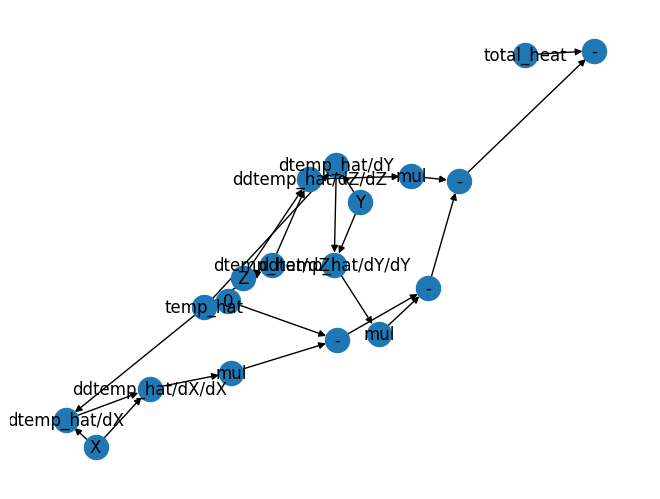

In [66]:
# check the shapes of the forward pass of the symbolic PINN terms
# print(dtemperature_dt({**net_out, **train_data.datadict}).shape)
print(dtemperature_dx({**net_out, **train_data.datadict}).shape)
print(dtemperature_dy({**net_out, **train_data.datadict}).shape)
print(dtemperature_dz({**net_out, **train_data.datadict}).shape)
print(d2temperatur_d2x({**net_out, **train_data.datadict}).shape)
print(d2temperatur_d2y({**net_out, **train_data.datadict}).shape)
print(d2temperatur_d2z({**net_out, **train_data.datadict}).shape)
print(f_pinn({**net_out, **train_data.datadict}).shape)

# computational graph of the PINN neural network
f_pinn.show()

In [67]:
# PDE CP loss
scaling = 100.

# PDE CP loss
ell_f = (scaling * (f_pinn == torch.tensor(0.).to(device)) ^ 2)

# PDE IC and BC loss
ell_u = (scaling * (temp_hat == Temp_var) ^ 2).to(device)

# # output constraints to bound the PINN solution in the PDE output domain [-1.0, 1.0]
con_1 = (scaling * (temp_hat <= torch.tensor(1.).to(device)) ^ 2).to(device)
con_2 = (scaling * (temp_hat >= torch.tensor(-1.).to(device)) ^ 2).to(device)

from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_f, ell_u], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],  # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,  # physics-informed loss function
                  grad_inference=True  # argument for allowing computation of gradients at the inference time)
                  )

In [68]:
from neuromancer.trainer import Trainer
from neuromancer.loggers import BasicLogger

optimizer = torch.optim.Adam(problem.parameters(), lr=0.1, )
epochs = 2000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_data = train_loader,
    dev_data = vali_loader,
    test_data = test_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=10,
    train_metric='train_loss',
    dev_metric='vali_loss',
    test_metric="test_loss",
    eval_metric="vali_loss",
    warmup=epochs,
    device=device,
)

In [69]:
# Train PINN
best_model = trainer.train()

c:\Users\Aereo\miniconda3\envs\thermal\lib\site-packages\neuromancer\constraint.py:163: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([1085, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\Aereo\miniconda3\envs\thermal\lib\site-packages\neuromancer\constraint.py:163: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([156, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\Aereo\miniconda3\envs\thermal\lib\site-packages\neuromancer\constraint.py:163: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



epoch: 0  train_loss: 10288040960.0
epoch: 10  train_loss: 10284086272.0
epoch: 20  train_loss: 10270633984.0
epoch: 30  train_loss: 10260238336.0
epoch: 40  train_loss: 10235309056.0
epoch: 50  train_loss: 10203004928.0
epoch: 60  train_loss: 10230269952.0
epoch: 70  train_loss: 10258221056.0
epoch: 80  train_loss: 10265779200.0
epoch: 90  train_loss: 10209948672.0
epoch: 100  train_loss: 10240292864.0
epoch: 110  train_loss: 10210646016.0
epoch: 120  train_loss: 10193693696.0
epoch: 130  train_loss: 10259975168.0
epoch: 140  train_loss: 10274714624.0
epoch: 150  train_loss: 10279000064.0
epoch: 160  train_loss: 10273257472.0
epoch: 170  train_loss: 10277386240.0
epoch: 180  train_loss: 10290903040.0
epoch: 190  train_loss: 10283655168.0
epoch: 200  train_loss: 10285177856.0
epoch: 210  train_loss: 10278183936.0
epoch: 220  train_loss: 10259858432.0
epoch: 230  train_loss: 10270244864.0
epoch: 240  train_loss: 10257085440.0
epoch: 250  train_loss: 10271602688.0
epoch: 260  train_loss:

In [70]:
def move_batch_to_device(batch, device="cpu"):
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

# load best trained model
problem.load_state_dict(best_model)

# evaluate trained PINN on test data
PINN = problem.nodes[0]

In [71]:
PINN(move_batch_to_device(train_data.datadict, device=device))

{'temp_hat': tensor([[73.7175],
         [73.7174],
         [73.7175],
         ...,
         [73.7175],
         [73.7174],
         [25.8057]], device='cuda:0', grad_fn=<AddmmBackward0>)}

In [72]:
f_pinn_loss = f_pinn({
    **PINN(move_batch_to_device(train_data.datadict, device=device)),
    **train_data.datadict
}).abs().detach().numpy().reshape(-1)

group = train_data.datadict['is_ic_bc'].detach().numpy().reshape(-1).astype(bool)

In [73]:
np.median(f_pinn_loss[group])

10654.682

In [74]:
np.median(f_pinn_loss[~group])

10782.033

In [75]:
np.median(PINN(move_batch_to_device(train_data.datadict, device=device))['temp_hat'].detach().cpu().numpy().reshape(-1))

73.71598